In [1]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
import spacy
import pandas as pd
nlp = spacy.load("en_core_web_sm")
# warnings imports
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from matplotlib.patches import Ellipse
from collections import Counter
from pyclustering.cluster.clarans import clarans
from pyclustering.utils import read_sample

In [2]:
df = pd.read_json("TP6_data.json",lines=True)
sentences = []
for sentence in df["sentences"].tolist():
    sentences.extend(sentence)

print("Total sentences:"+str(len(sentences)))
labels = []
for label in df["labels"].tolist():
    labels.extend(label)

print("Total labels:"+str(len(set(labels))))

counter = Counter(labels)
most_common_items = counter.most_common(5)

print("5 most frequent items:")
for item, count in most_common_items:
    print(f"{item}: {count} occurrences")

Total sentences:420464
Total labels:50
5 most frequent items:
collapse.txt: 12297 occurrences
comicbooks.txt: 11251 occurrences
classicalmusic.txt: 11131 occurrences
Coffee.txt: 10680 occurrences
aviation.txt: 10393 occurrences


In [14]:
data = list(zip(sentences, labels))

selected_labels = ['advertising.txt','canada.txt']

n = 500

selected_data = []
selected_label = []

for label in selected_labels:
    filtered_data = [(sentence, l) for sentence, l in data if l == label]
    for i in range(n):
        selected_data.append(filtered_data[i][0])
    selected_label.extend([label] * min(n, len(filtered_data)))

In [4]:
k = len(selected_labels)
print(k)
data=selected_data

vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, stop_words='english',use_idf=True)
X = vectorizer.fit_transform(data)
print("n_samples: %d, n_features: %d" % X.shape)

n_components = 5
svd = TruncatedSVD(n_components)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X = lsa.fit_transform(X)

2
n_samples: 1000, n_features: 3375


c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  s

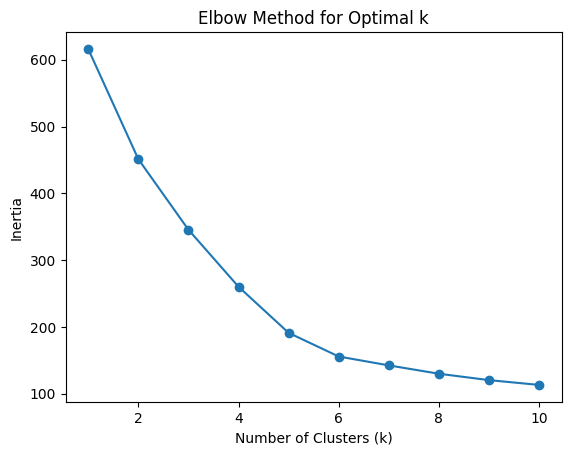

In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia_values = []
k_values = range(1, 11)

for temp_k in k_values:
    kmeans = KMeans(n_clusters=temp_k, random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


In [6]:
kmeans = KMeans(n_clusters = k, random_state = 0, n_init='auto',max_iter=30000)
kmeans.fit(X)
original_space_centroids = svd.inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(k):
   print("Cluster %d:" % i)
   for ind in order_centroids[i, :10]:
      print(' %s' % terms[ind])



Cluster 0:
 canada
 trudeau
 canadian
 justin
 need
 dollar
 ads
 new
 health
 ad
Cluster 1:
 advertising
 ad
 ads
 online
 india
 delhi
 agency
 new
 canada
 best


In [7]:
def convert_labels_to_integers(labels):
    unique_labels, integer_labels = np.unique(labels, return_inverse=True)
    return integer_labels, dict(zip(unique_labels, range(len(unique_labels))))

integer_labels, label_mapping = convert_labels_to_integers(selected_label)


In [8]:

print("Homogeneity: %0.3f" % metrics.homogeneity_score(integer_labels, kmeans.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(integer_labels, kmeans.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(integer_labels, kmeans.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(integer_labels, kmeans.labels_))
print("Silhouette Coefficient: %0.3f "
      % metrics.silhouette_score(X, kmeans.labels_, sample_size=1000))

Homogeneity: 0.398
Completeness: 0.398
V-measure: 0.398
Adjusted Rand-Index: 0.498
Silhouette Coefficient: 0.297 


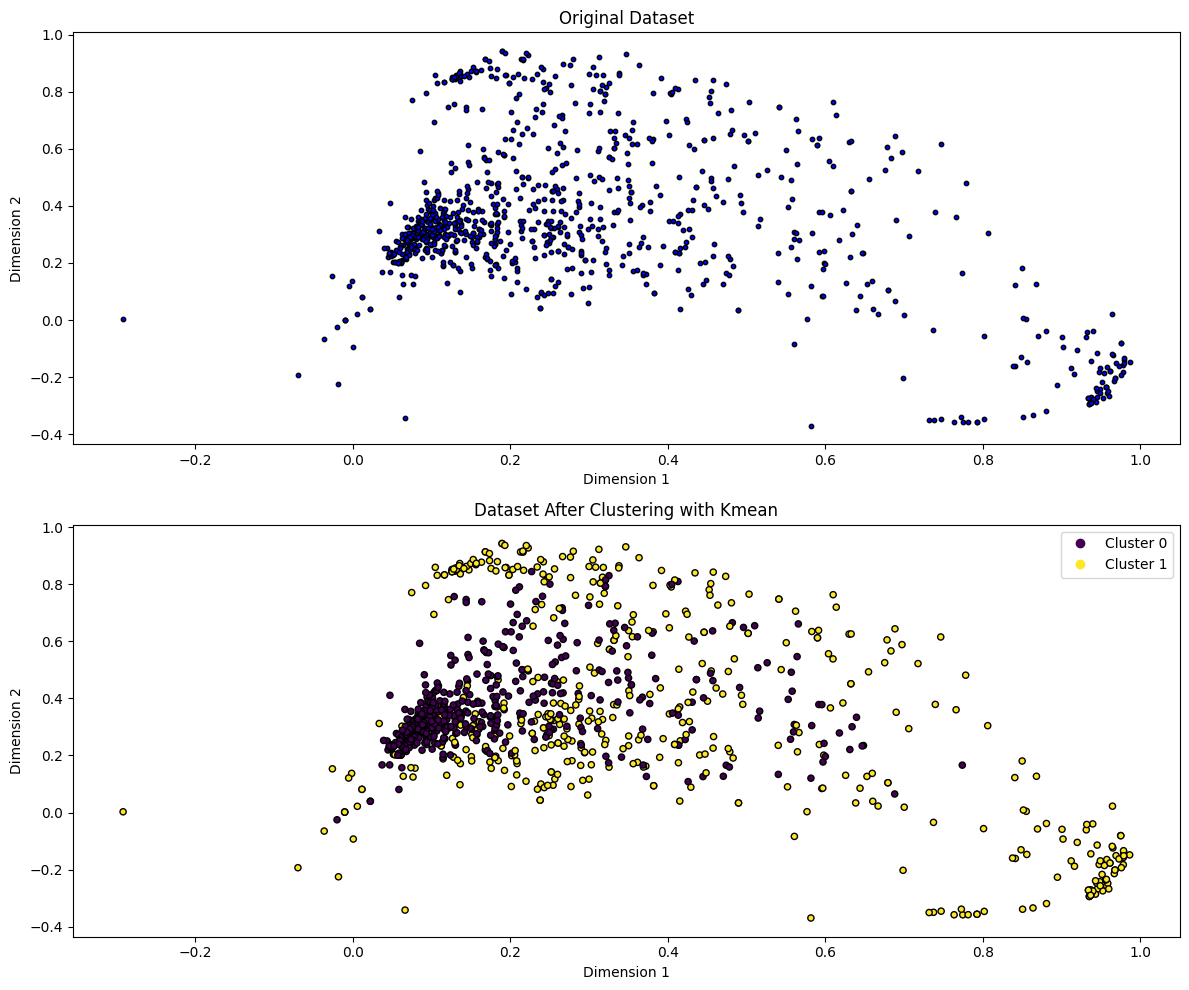

In [10]:
cluster_assignments = kmeans.predict(X)
cluster_centers = kmeans.cluster_centers_

fig, axs = plt.subplots(2, 1, figsize=(12, 10))

axs[0].scatter(X[:, 0], X[:, 1], c='blue', marker='o', edgecolors='k', s=10)
axs[0].set_title('Original Dataset')
axs[0].set_xlabel('Dimension 1')
axs[0].set_ylabel('Dimension 2')

scatter = axs[1].scatter(X[:, 0], X[:, 1], c=cluster_assignments, cmap='viridis', marker='o', edgecolors='k', s=20)



axs[1].set_title('Dataset After Clustering with Kmean')
axs[1].set_xlabel('Dimension 1')
axs[1].set_ylabel('Dimension 2')

legend_labels = [f'Cluster {i}' for i in range(k)]
axs[1].legend(handles=scatter.legend_elements()[0], labels=legend_labels, loc='upper right')

plt.tight_layout()
plt.show()

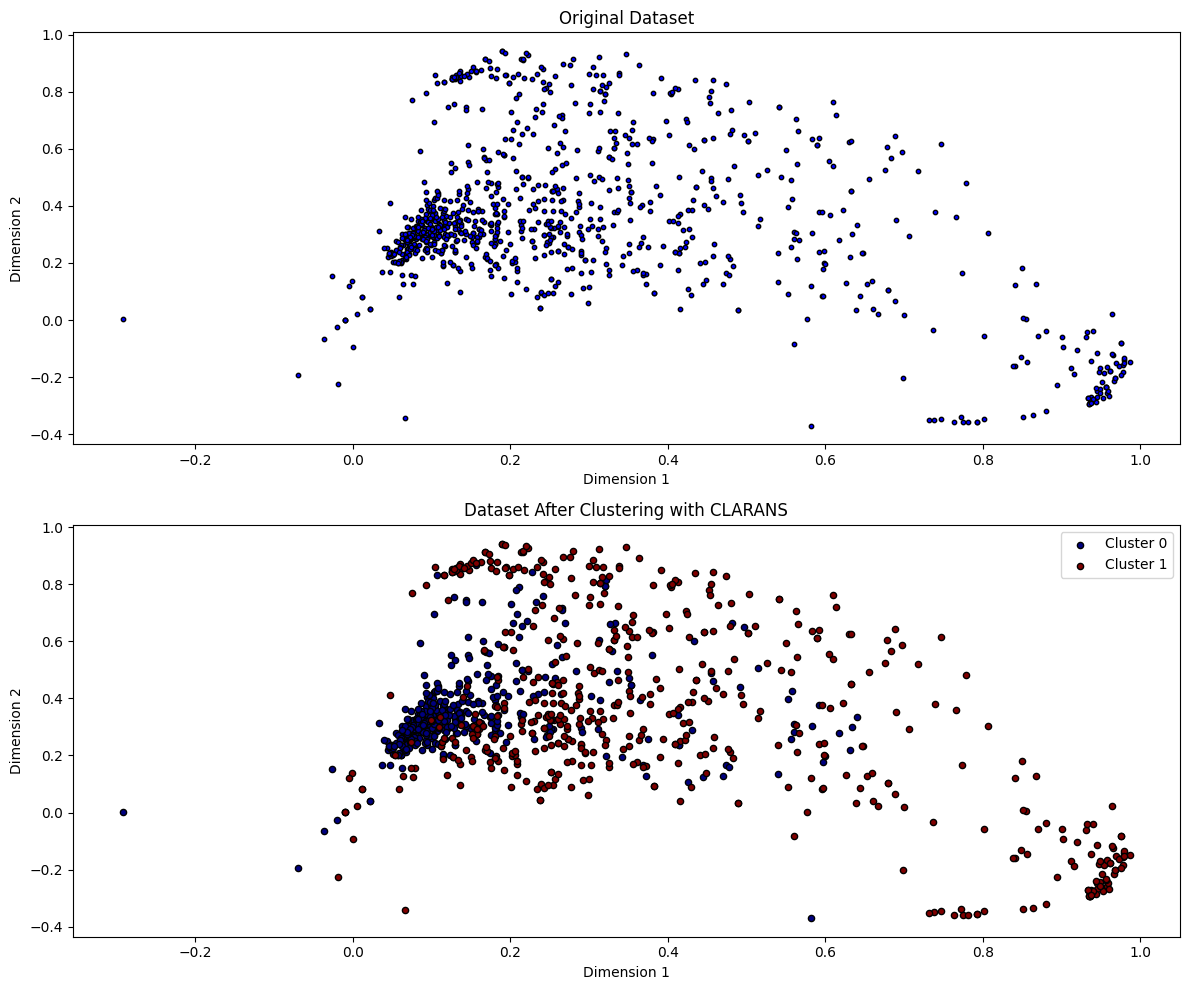

In [11]:

clarans_instance = clarans(X, k, 2,2)

clarans_instance.process()
cluster_assignments = clarans_instance.get_clusters()

fig, axs = plt.subplots(2, 1, figsize=(12, 10))

axs[0].scatter(X[:, 0], X[:, 1], c='blue', marker='o', edgecolors='k', s=10)
axs[0].set_title('Original Dataset')
axs[0].set_xlabel('Dimension 1')
axs[0].set_ylabel('Dimension 2')

colors = plt.cm.jet(np.linspace(0, 1, len(cluster_assignments)))
for i, cluster_points in enumerate(cluster_assignments):
    cluster_points = np.array(cluster_points)
    axs[1].scatter(X[cluster_points, 0], X[cluster_points, 1], c=[colors[i]], label=f'Cluster {i}', marker='o', edgecolors='k', s=20)

axs[1].set_title('Dataset After Clustering with CLARANS')
axs[1].set_xlabel('Dimension 1')
axs[1].set_ylabel('Dimension 2')
axs[1].legend(loc='upper right')

plt.tight_layout()
plt.show()


In [12]:
def extract_labels_from_clusters(clusters):
    labels = [-1] * sum(map(len, clusters))
    for cluster_label, cluster_indices in enumerate(clusters):
        for data_point_index in cluster_indices:
            labels[data_point_index] = cluster_label
    return labels

clusters = [[0, 1, 2], [3, 4], [5, 6, 7]]

cluster_labels = extract_labels_from_clusters(clusters)

In [13]:
clarans_labels=extract_labels_from_clusters(cluster_assignments)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(integer_labels,clarans_labels))
print("Completeness: %0.3f" % metrics.completeness_score(integer_labels,clarans_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(integer_labels, clarans_labels))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(integer_labels, clarans_labels))
print("Silhouette Coefficient: %0.3f "
      % metrics.silhouette_score(X,clarans_labels, sample_size=1000))

Homogeneity: 0.330
Completeness: 0.334
V-measure: 0.332
Adjusted Rand-Index: 0.412
Silhouette Coefficient: 0.261 
